## Import package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Exploration & Intuition

In [4]:
df_train=pd.read_csv("./original_data/mitbih_train.csv")
df_test=pd.read_csv("./original_data/mitbih_test.csv")

In [5]:
df_train.columns = np.arange(188)
df_test.columns = np.arange(188)

In [6]:
X_train_=df_train.iloc[:,:-1]
y_train=df_train.iloc[:,-1]
X_test=df_test.iloc[:,:-1]
y_test=df_test.iloc[:,-1]

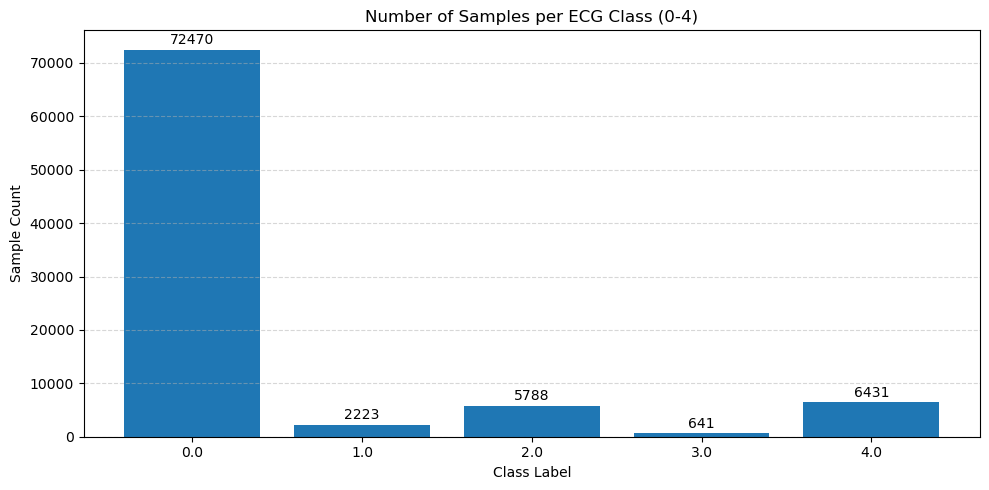

In [7]:
class_counts = y_train.value_counts().sort_index()

plt.figure(figsize=(10, 5))
bars = plt.bar(class_counts.index.astype(str), class_counts.values)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height + 500,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.title("Number of Samples per ECG Class (0-4)")
plt.xlabel("Class Label")
plt.ylabel("Sample Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


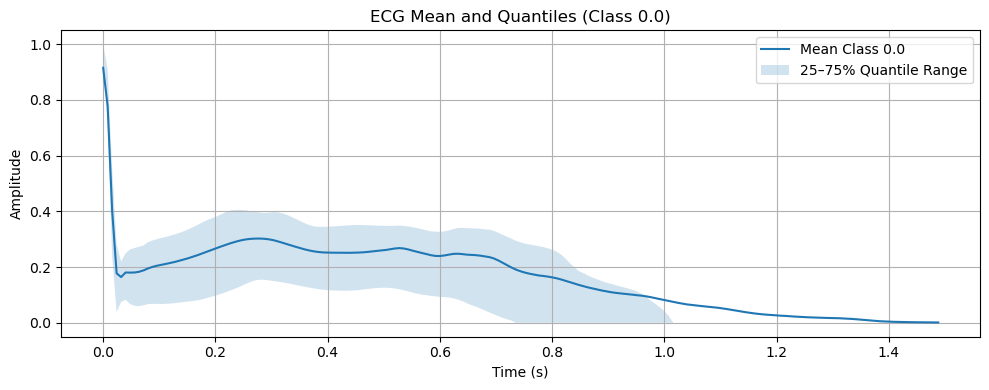

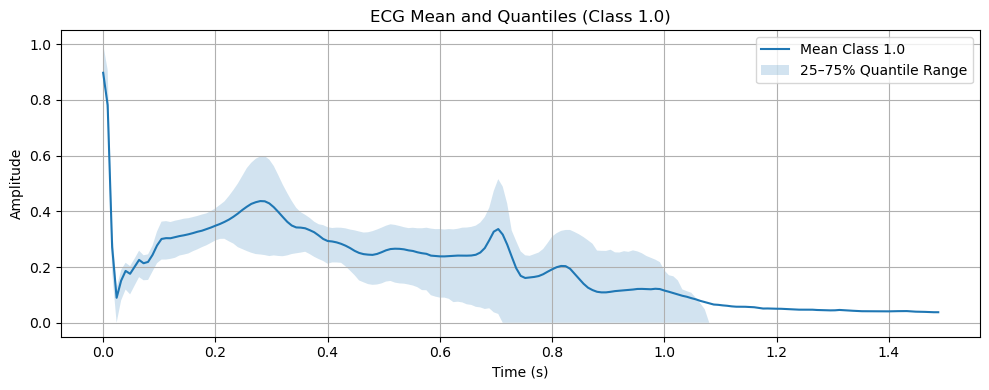

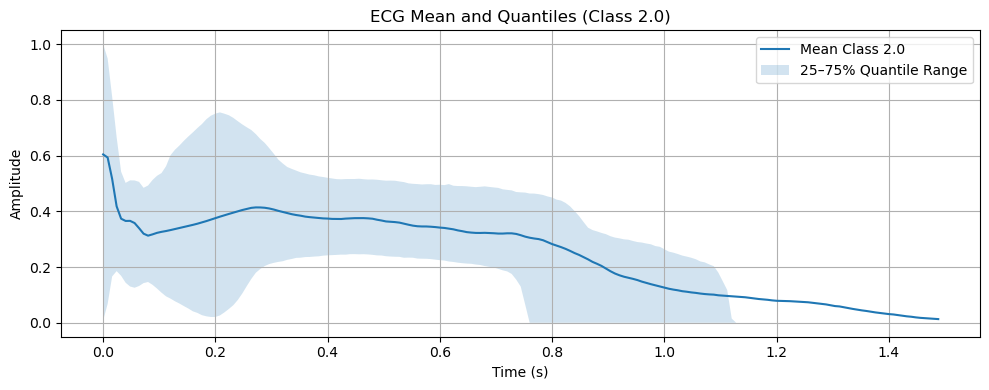

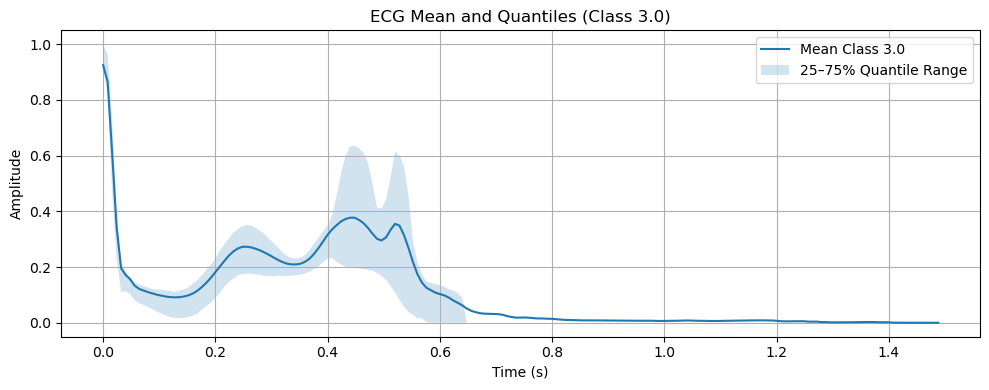

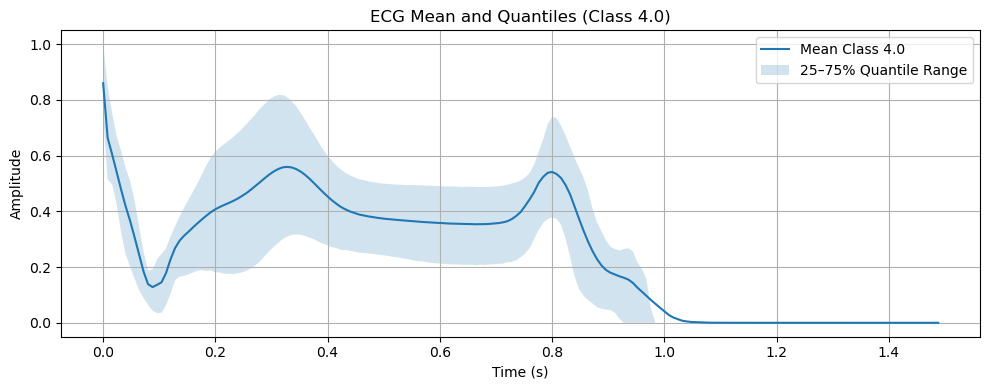

In [8]:
classes = sorted(y_train.unique())

lower_q = 0.25
upper_q = 0.75

for label in classes:
    class_samples = X_train_[y_train == label]
    
    mean_waveform = class_samples.mean(axis=0)
    lower_quantile = class_samples.quantile(lower_q, axis=0)
    upper_quantile = class_samples.quantile(upper_q, axis=0)
    
    t = np.arange(class_samples.shape[1]) / 125

    plt.figure(figsize=(10, 4))
    plt.plot(t, mean_waveform, label=f"Mean Class {label}")
    plt.fill_between(t, lower_quantile, upper_quantile, alpha=0.2,
                     label=f"{int(lower_q*100)}–{int(upper_q*100)}% Quantile Range")
    
    plt.title(f"ECG Mean and Quantiles (Class {label})")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Resampling

In [10]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

under_sampler = RandomUnderSampler(sampling_strategy={0: 20000}) 
over_sampler = SMOTETomek(sampling_strategy={1: 20000, 
                                        2: 20000, 
                                        3: 20000, 
                                        4: 20000})

pipeline = Pipeline([
    ('under', under_sampler), 
    ('over', over_sampler)   
])

X_resampled, y_resampled = pipeline.fit_resample(X_train_, y_train)


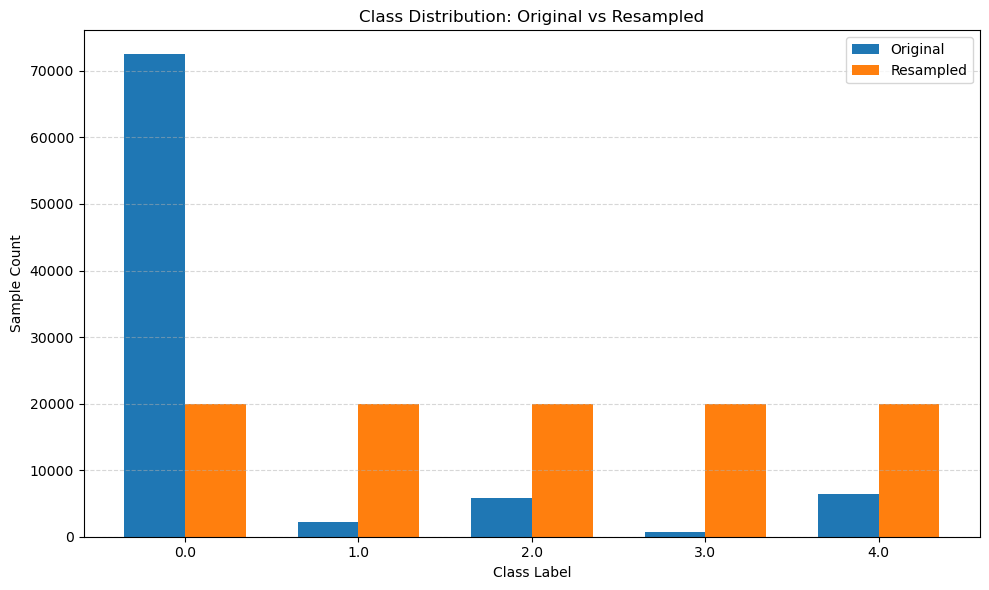

In [11]:
original_counts = y_train.value_counts().sort_index()
resampled_counts = pd.Series(y_resampled).value_counts().sort_index()

classes = original_counts.index.tolist()
x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, original_counts.values, width=width, label="Original")
plt.bar(x + width/2, resampled_counts.values, width=width, label="Resampled")

plt.xlabel("Class Label")
plt.ylabel("Sample Count")
plt.title("Class Distribution: Original vs Resampled")
plt.xticks(x, classes)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## XGBOOST

In [14]:
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, make_scorer

In [15]:
def custom_weighted_recall(y_true, y_pred):
    recalls = recall_score(y_true, y_pred, average=None, labels=[0, 1, 2, 3, 4])
    weights = np.array([0.1, 1, 1, 1, 1])
    return np.sum(recalls * weights) / np.sum(weights)
    
weighted_recall_scorer = make_scorer(custom_weighted_recall, greater_is_better=True)

In [18]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 300, 1000],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

search = RandomizedSearchCV(
    XGBClassifier(objective='multi:softmax', num_class=5, random_state=42,tree_method='hist',device='cuda'),
    param_distributions=param_grid,
    n_iter=20,
    scoring= weighted_recall_scorer,
    cv=3,
    verbose=3,
    n_jobs=-1
)

search.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/pockyee/miniconda3/envs/ds_env/lib/python3.13/site-packages/xgboost/core.py:729: UserWarning: [15:06:42] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/pockyee/miniconda3/envs/ds_env/lib/python3.13/site-packages/xgboost/core.py:729: UserWarning: [15:06:42] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device='cuda',
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constra...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_class=5, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [4, 6, 8],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 300, 1000],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring=make_scorer(custom_weighted_recall, response_method='predict'),
                   verbose=3)

In [19]:
search.best_params_

{'subsample': 0.6,
 'n_estimators': 1000,
 'min_child_weight': 3,
 'max_depth': 8,
 'learning_rate': 0.1,
 'colsample_bytree': 0.6}

In [20]:
xgb_model = search.best_estimator_

In [21]:
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

/home/pockyee/miniconda3/envs/ds_env/lib/python3.13/site-packages/xgboost/core.py:729: UserWarning: [15:15:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1744352594194/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


              precision    recall  f1-score   support

         0.0     0.9903    0.9785    0.9844     18117
         1.0     0.6419    0.7932    0.7096       556
         2.0     0.9316    0.9599    0.9456      1448
         3.0     0.7151    0.8210    0.7644       162
         4.0     0.9729    0.9826    0.9777      1608

    accuracy                         0.9717     21891
   macro avg     0.8504    0.9070    0.8763     21891
weighted avg     0.9742    0.9717    0.9727     21891



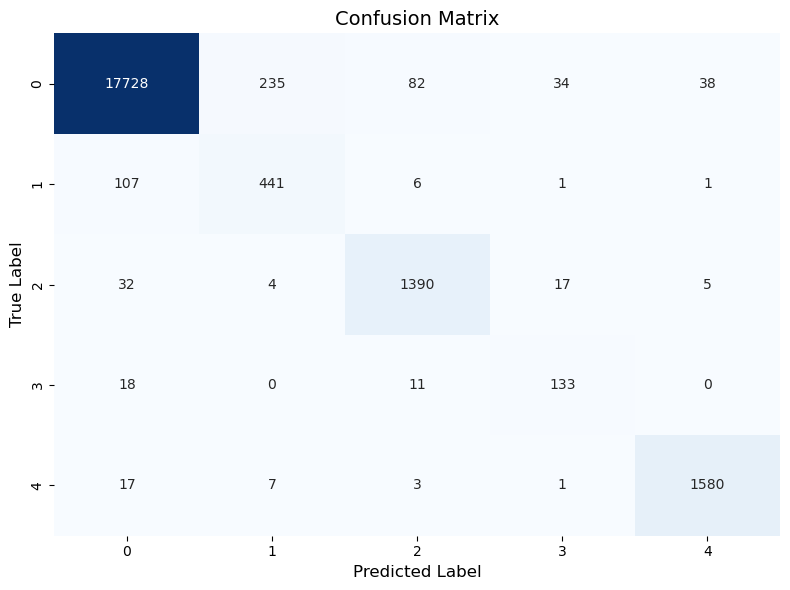

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [23]:
xgb_model.save_model('xgb_model.json')

[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=300, subsample=0.6;, score=0.988 total time=  10.8s
[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=300, subsample=0.6;, score=0.991 total time=   8.8s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=100, subsample=1.0;, score=0.886 total time=   4.1s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=100, subsample=0.6;, score=0.946 total time=   4.1s
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.6;, score=0.895 total time=   2.3s
[CV 3/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.6;, score=0.907 total time=   2.7s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, min_child_weight=1, 

Exception ignored in: <function ResourceTracker.__del__ at 0x75507b8876a0>
Traceback (most recent call last):
  File "/home/pockyee/miniconda3/envs/ds_env/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/pockyee/miniconda3/envs/ds_env/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/pockyee/miniconda3/envs/ds_env/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
